# Flight departure delay predictions
## PageRank and proxy categorical variables for airports

## Package imports, directories and configuration

In [ ]:
# install networkx for visualization (Spark does not have a native way to create a visualization of a graph)
%pip install networkx

In [ ]:
# install geopandas (to aid visualization)
%pip install geopandas

In [0]:
# package imports
from pyspark.sql.functions import col, isnull, broadcast, udf, count, when, isnan, lpad, to_timestamp, concat, to_utc_timestamp, lit 
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import Bucketizer

from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from functools import reduce
from graphframes import *

import numpy as np
import math

import networkx as nx
import matplotlib.pyplot as plt
import geopandas


In [ ]:
#data path to directory 
path = 'dbfs:/path/'

In [ ]:
# spark configuration
sc = spark.sparkContext
sqlContext = SQLContext(sc)
sc.getConf().getAll()

## Functions
Functions to help create a visualization using the networkx package.

In [0]:
# function to create networkx graph from edges in graphx
def create_networkx(edge_list):
    g = nx.Graph()
    for row in edge_list.select('src','dst').take(8000):
        g.add_edge(row['src'],row['dst'])
    return g
  
# function to create a node position dictionary from dataframe
def pos_dict(position):
  # initialize empty dictionary
  pos = {}
  for row in position.select('id','longitude_deg','latitude_deg').take(400):
    pos[row['id']] = (row['longitude_deg'], row['latitude_deg'])
    
  return pos



## PageRank

Calculate the PageRank for the airports in the dataset. First create a graph dataframe and then use it to calculate the PageRank.

The PageRank algorithm measures the importance of each node (in this case airport) within the graph, based on the number incoming relationships (incoming routes from other airports) and the importance of the corresponding source nodes (other airports). The assumption is that if an airport with many connections is delayed, this delay will likely propagate to other airports.

Using the nodes degrees in the graph, create a proxy categorical variable to represent the airports based on their size (number of incoming/outgoing connections).

In [0]:
# Load pre-processed airlines data

df_airlines = spark.read.parquet("/data/airlines_processed.parquet")

print(f'{df_airlines.count():,} flight records loaded')


31,746,836 flight records loaded

In [0]:
# extract unique origin and destination airports
origin_airports = df_airlines.select('ORIGIN').distinct()
dest_airports = df_airlines.select('DEST').distinct()
vertices = origin_airports.union(dest_airports).distinct()

In [0]:
# create vertex dataframe. A vertex DataFrame should contain a special column named "id" which specifies unique IDs for each vertex 
vertices = vertices.withColumnRenamed('ORIGIN', 'id') 

In [0]:
# create an edge dataframe. 
# An edge DataFrame should contain two special columns: "src" (source vertex ID of edge) and "dst" (destination vertex ID of edge).
edges = df_airlines.select('ORIGIN', "DEST").drop_duplicates() \
                   .withColumnRenamed('ORIGIN', 'src') \
                   .withColumnRenamed('DEST', 'dst') 

In [0]:
edges.count()

Out[16]: 7269

In [0]:
# create a graph dataframe 
from graphframes import GraphFrame
g = GraphFrame(vertices, edges)
print(g)

GraphFrame(v:[id: string], e:[src: string, dst: string])

In [0]:
display(g.vertices)

id
BGM
INL
PSE
DLG
MSY
PPG
GEG
DRT
SNA
BUR


In [0]:
display(g.inDegrees)

id,inDegree
PSE,2
MSY,55
GEG,19
SNA,27
BUR,19
GTF,8
GRB,7
IFP,1
IDA,7
GRR,33


Nodes with no edges going in: EFD, ENV, TKI

In [0]:
display(g.outDegrees)

id,outDegree
PSE,2
MSY,54
DRT,1
GEG,21
SNA,26
BUR,18
GTF,8
GRB,11
IDA,7
GRR,35


Nodes with no edges going out: FNL. Need to consider teleporting when calculating the PageRank.

In [0]:
g_degree = g.degrees
display(g_degree)

id,degree
BGM,2
DLG,2
INL,6
MSY,109
PPG,2
GEG,40
DRT,2
BUR,37
SNA,53
GRB,18


In [0]:
# Calculate pagerank. Number of iterations = 1
results = g.pageRank(resetProbability=0.15, maxIter=1)
display(results.vertices)

id,pagerank
BGM,0.1571050082433621
INL,0.7245265504434338
PSE,0.17061955070255827
DLG,0.17696685976020488
MSY,1.1594327077263011
PPG,0.1778256769500203
GEG,0.5429652281738528
DRT,0.1549238852216086
SNA,0.4512655198131339
BUR,0.39639902315564807


In [0]:
# Calculate pagerank. Number of iterations = 2
results = g.pageRank(resetProbability=0.15, maxIter=2)
display(results.vertices)

id,pagerank
BGM,0.20759575690211962
INL,0.4693122044879138
PSE,0.23470145168416182
DLG,0.3380474868323357
MSY,2.127747420786795
PPG,0.21095441850185667
GEG,1.218853314640215
DRT,0.25777370152563295
SNA,1.3383550910657107
BUR,0.9552784831787648


In [0]:
# Calculate pagerank. Number of iterations = 3
results = g.pageRank(resetProbability=0.15, maxIter=3)
display(results.vertices)

id,pagerank
BGM,0.1825373817386647
PSE,0.20735236056396622
INL,0.4291574755472857
DLG,0.24273471530978857
MSY,1.9459490020997756
PPG,0.21234109068522536
GEG,0.8968696868892382
DRT,0.18786537814699164
BUR,0.7773103682139847
SNA,1.0218609328245782


In [0]:
# Calculate pagerank. Number of iterations = 4
results = g.pageRank(resetProbability=0.15, maxIter=4)
display(results.vertices)

id,pagerank
BGM,0.19476608467188447
INL,0.3828100698982596
DLG,0.2533178069148038
PSE,0.22533738088173602
MSY,2.2078017564836583
PPG,0.19911500118662345
GEG,1.04311430240205
DRT,0.20984745024424967
SNA,1.2377607245318816
BUR,0.9117798994042656


In [0]:
# Calculate pagerank. Number of iterations = 5
results = g.pageRank(resetProbability=0.15, maxIter=5)
display(results.vertices)

id,pagerank
BGM,0.18815419474192716
INL,0.374692458709169
DLG,0.24033724307469947
PSE,0.21986561860754433
MSY,2.1408573245644043
PPG,0.2047925819203643
GEG,0.9589410740651921
DRT,0.19532380982463987
SNA,1.1421202262716919
BUR,0.8564096076974841


In [0]:
# Calculate pagerank. Number of iterations = 6
results = g.pageRank(resetProbability=0.15, maxIter=6)
display(results.vertices)

id,pagerank
BGM,0.1918999169190376
INL,0.3659947043452413
PSE,0.22495744003182105
DLG,0.23728133934746162
MSY,2.206425741886579
PPG,0.19974216181303336
GEG,0.9909585384412887
DRT,0.20155574268710014
SNA,1.198562840149986
BUR,0.8906289915445452


In [0]:
# Calculate pagerank. Number of iterations = 7
results = g.pageRank(resetProbability=0.15, maxIter=7)
display(results.vertices)

id,pagerank
BTM,0.2846184230064744
OGS,0.3071577127510432
ATW,0.6343970540723382
ALO,0.19700588102731964
HTS,0.4109251489482922
YAK,0.4698290090587952
DLG,0.2351468538977226
SNA,1.1710776218211965
BOS,2.903349800934881
IMT,0.4032778522634126


In [0]:
# Calculate pagerank. Number of iterations = 8
results = g.pageRank(resetProbability=0.15, maxIter=8)
display(results.vertices)

id,pagerank
BGM,0.19114511147281674
INL,0.362676865330537
PSE,0.22466179259616587
DLG,0.23306941388655225
MSY,2.2048634732586625
PPG,0.19971920794277948
GEG,0.9761012348594785
DRT,0.19973675209950273
SNA,1.1866052327589427
BUR,0.8836358993856587


In [0]:
# Calculate pagerank. Number of iterations = 9
results = g.pageRank(resetProbability=0.15, maxIter=9)
display(results.vertices)

id,pagerank
BGM,0.19059953295130205
PSE,0.22411302808595354
BNA,2.898430064917713
CGI,0.520571698346648
DLG,0.23255226666027534
BLI,0.813400534569197
CLL,0.38588581351587026
INL,0.3623562116814017
CLT,6.7751676502564875
PSC,0.4850968144401087


In [0]:
# Calculate pagerank. Number of iterations = 10
results = g.pageRank(resetProbability=0.15, maxIter=10)
display(results.vertices)

id,pagerank
BGM,0.19095252087491885
INL,0.36204135613541827
PSE,0.22455215853472793
DLG,0.23164604818345264
MSY,2.2046717365680646
PPG,0.19961755963623798
GEG,0.9715617740881916
DRT,0.19929060032183812
SNA,1.1831060197142826
BUR,0.8814663862445431


Stop at 10 iterations as the difference between iterations is low (and the processing time is high). Comparing the results of 9 iterations and 10 iterations: maximum percentage change in the PageRank values is 1.5%, and in average the percentage change in the PageRank values is 0.4%.

In [ ]:
# Save pagerank results to parquet

dbutils.fs.rm(path + "/data/" + "pagerank.parquet", recurse =True)
results.vertices.write.parquet(path + "/data/" + "pagerank.parquet")


## Proxy Categorical variables for airports

Using the nodes degrees in the graph, create a proxy categorical variable to represent the airports based on their size (number of incoming/outgoing connections).

In [0]:
# Load previusly calculated PageRank

df_pagerank = spark.read.parquet("/data/pagerank.parquet")

print(f'{df_pagerank.count():,} PageRank records loaded')

372 PageRank records loaded

In [0]:
display(df_pagerank)

id,pagerank
PVD,1.1933457366130695
ILG,0.2217312735725514
OAK,2.2180940581049677
MQT,0.48335487900013574
FAR,0.6267937928098927
PRC,0.2396584705394431
EAR,0.24602355704389803
BKG,0.2949087289138029
PIB,0.33109506014352663
FCA,0.6238854138507436


In [0]:
# rename id column in g_degree dataframe before merging
g_degree = g_degree.withColumnRenamed('id','id2')
display(g_degree)

id2,degree
BGM,2
DLG,2
INL,6
MSY,109
PPG,2
GEG,40
DRT,2
SNA,53
BUR,37
GRB,18


In [0]:
# join PageRank data and degrees data
df_page_degree = df_pagerank.join(broadcast(g_degree), df_pagerank.id == g_degree.id2, 'left')

# list of columns to keep
columns = ['id', 'pagerank', 'degree']

# select columns to keep
df_page_degree = df_page_degree.select(*columns)

In [0]:
display(df_page_degree)

id,pagerank,degree
PVD,1.1933457366130695,56
ILG,0.2217312735725514,4
OAK,2.2180940581049677,106
MQT,0.48335487900013574,11
FAR,0.6267937928098927,24
PRC,0.2396584705394431,4
EAR,0.24602355704389803,4
BKG,0.2949087289138029,6
PIB,0.33109506014352663,4
FCA,0.6238854138507436,23


In [0]:
# group airports in buckets depending on the degree

bucketizer = Bucketizer(splits=[0,10,50,150,300,400],inputCol='degree', outputCol='airport_size_group')

df_buck = bucketizer.setHandleInvalid('keep').transform(df_page_degree)

In [0]:
display(df_buck)

id,pagerank,degree,airport_size_group
PVD,1.1933457366130695,56,2.0
ILG,0.2217312735725514,4,0.0
OAK,2.2180940581049677,106,2.0
MQT,0.48335487900013574,11,1.0
FAR,0.6267937928098927,24,1.0
PRC,0.2396584705394431,4,0.0
EAR,0.24602355704389803,4,0.0
BKG,0.2949087289138029,6,0.0
PIB,0.33109506014352663,4,0.0
FCA,0.6238854138507436,23,1.0


In [ ]:
# Save results to parquet- This file contains both the information of PageRank, degree and proxy categorical variable

dbutils.fs.rm(path + "/data/" + "pagerank_degree.parquet", recurse =True)
df_buck.write.parquet(path + "/data/" + "pagerank_degree.parquet")


## Graph visualization
Create a visualization of the graph.

### Get latitude and longitude
Use the same code of the main notebook.

In [0]:
# File location and type

# Load data downloaded from https://data.humdata.org/dataset/ourairports-usa
file_location = "/FileStore/shared_uploads/data/us_airports.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
  
# The applied options are for CSV files. For other file types, these will be ignored.
df_airports_location = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# only keep airports where the iata code is not null and airport is not closed
df_airports_location = df_airports_location.where((col('iata_code').isNotNull()) & (col('type') != 'closed'))

# print number of records
print(f'Number of airport locations loaded: {df_airports_location.count()}')

# select relevant columns 
airports_columns = ['iata_code', 'latitude_deg', 'longitude_deg', 'local_region']

# keep only relevant columns 
df_airports_location = df_airports_location.select(*airports_columns)

# print number of columns
print(f'Number of columns in airports dataset: {len(df_airports_location.columns)}')

# Add manually rows for nine airports corresponding mostly to US territories that are not in the uploaded csv
# Not in the cvs file: PSE, PPG, SPN, SJU, STX, GUM, BQN, ISN, STT
extra_airports = spark.createDataFrame([('PSE',18.0106,-66.5632,'PR'), ('PPG',-14.3290,-170.7132,'AS'), ('SPN',15.1197, 145.7283,'GU'),\
                                        ('SJU',18.4373, -66.0041,'PR'), ('STX',17.6995, -64.7975,'VI'), ('GUM',13.4853, 144.8008,'GU'), \
                                        ('BQN',18.4954, -67.1356,'PR'), ('ISN',48.1776, -103.6376,'ND'), ('STT',18.3361, -64.9723,'VI')
                                       ], ['iata_code', 'latitude_deg', 'longitude_deg', 'local_region'])

df_airports_location = df_airports_location.union(extra_airports)

# print number of records
print(f'Number of airport locations after adding data: {df_airports_location.count()}')

Number of airport locations loaded: 1973
Number of columns in airports dataset: 4
Number of airport locations after adding data: 1982

In [0]:
display(df_airports_location)

iata_code,latitude_deg,longitude_deg,local_region
LAX,33.942501,-118.407997,CA
ORD,41.9786,-87.9048,IL
JFK,40.639801,-73.7789,NY
ATL,33.6367,-84.428101,GA
SFO,37.6189994812012,-122.375,CA
EWR,40.692501,-74.168701,NJ
DFW,32.896801,-97.038002,TX
LAS,36.08010101,-115.1520004,NV
DEN,39.861698150635,-104.672996521,CO
MCO,28.4293994903564,-81.3089981079102,FL


In [0]:
# display graphframe edges
display(g.edges)

src,dst
PHL,MCO
SNA,PHX
FSD,ATL
SPI,ORD
MCI,IAH
CAE,ATL
JFK,ORD
AZA,MOT
WRG,PSG
ATL,HDN


In [0]:
# create graph in networkx format using the helper function
graph = create_networkx(g.edges)

In [0]:
# create a dataframe with vertices (airports) and longitude and latitude
position = vertices.join(broadcast(df_airports_location), vertices.id == df_airports_location.iata_code, 'left')
position = position.select(['id', 'longitude_deg', 'latitude_deg'])
display(position)

id,longitude_deg,latitude_deg
BGM,-75.97979736,42.20869827
PSE,-66.5632,18.0106
INL,-93.4030990600586,48.5662002563477
DLG,-158.5050049,59.04470062
MSY,-90.2580032348633,29.9934005737305
PPG,-170.7132,-14.329
GEG,-117.533996582031,47.6198997497559
DRT,-100.927001953,29.3742008209
SNA,-117.8679962,33.67570114
BUR,-118.356378,34.197703


In [0]:
# create node position (longitude, latitude) dictionary using the helper function
pos = pos_dict(position)

In [0]:
# add position attribute to the graph
nx.set_node_attributes(graph, pos, 'pos')

In [0]:
# eliminate nodes that are outside of US land to improve the visualization

# remove them from the position dictionary 
pos.pop('GUM')
pos.pop('SPN')
pos.pop('PPG')

# remove nodes in graph 
graph.remove_node('GUM')
graph.remove_node('SPN')
graph.remove_node('PPG')

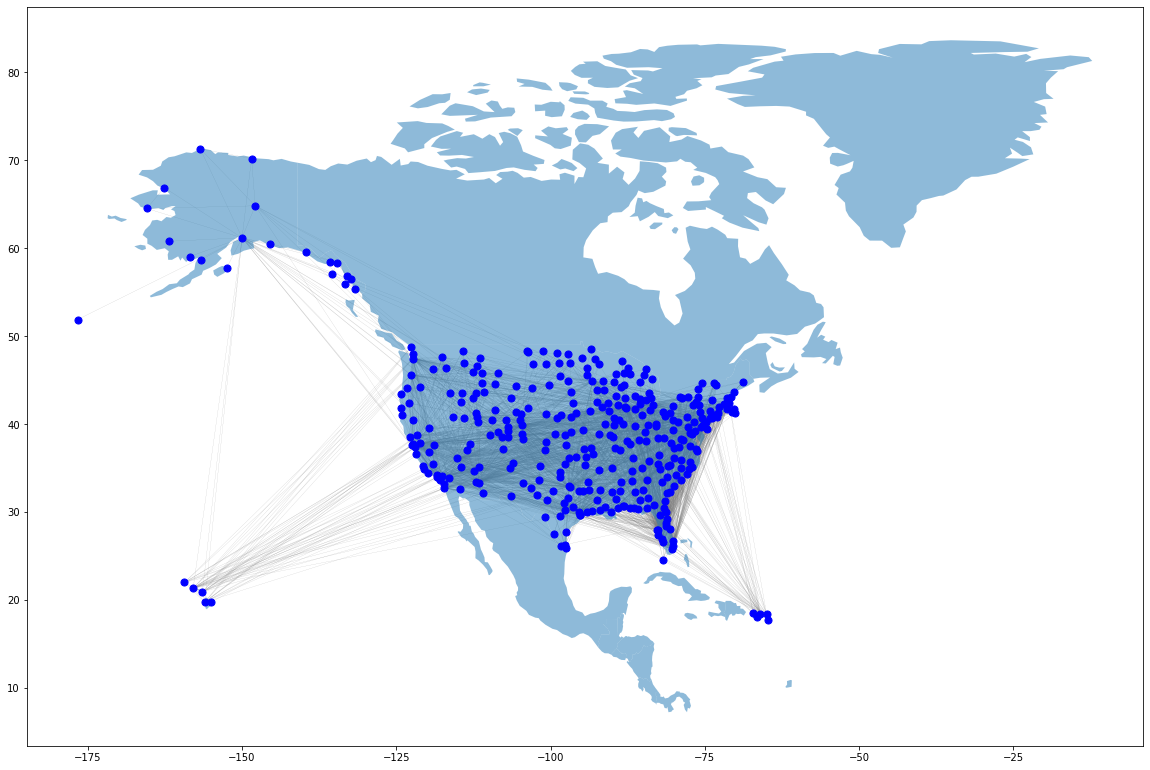

In [0]:
# load world map information from geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# create graph visualization
fig, ax = plt.subplots(figsize=(20, 15))
nx.draw(graph, nx.get_node_attributes(graph, 'pos'), with_labels=False, node_size=50, node_color='blue', edge_color='grey' ,ax=ax, width=0.1)
world[world.continent =='North America'].plot(alpha=0.5, edgecolor=None, ax=ax)
limits=plt.axis('on') # turns on axis
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)